In [1]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import madrigalWeb.madrigalWeb
import re
import h5py
import numpy as np

In [2]:
#CHANGE ME
user_fullname = "Student Example"
user_email = "isr.summer.school@gmail.com"
user_affiliation = "ISR Summer School 2020"

maddat = madrigalWeb.madrigalWeb.MadrigalData('http://isr.sri.com/madrigal')

In [3]:
#instrument codes for AMISR
instcodes={'PFISR':61,
          'RISR-N':91,
          'RISR-C':92}

In [4]:
#start time
st=datetime.datetime(2011,8,4,0,0,0)
et=datetime.datetime(2011,8,5,0,0,0)
expList = maddat.getExperiments(instcodes['PFISR'], st.year, st.month, st.day, st.hour, st.minute, st.second, et.year, et.month, et.day, et.hour, et.minute, et.second)
for exp in expList:
    print(exp)

id: 30002976
realUrl: http://isr.sri.com/madrigal/cgi-bin/madExperiment.cgi?exp=2011/pfa/01aug11a&displayLevel=0&expTitle=MSWinds23+-+D-region+E-region+F-region+local+measurements
url: http://isr.sri.com/madrigal/cgi-bin/madtoc/2011/pfa/01aug11a
name: MSWinds23 - D-region E-region F-region local measurements
siteid: 3
sitename: SRI
instcode: 61
instname: Poker Flat IS Radar
startyear: 2011
startmonth: 8
startday: 1
starthour: 0
startmin: 4
startsec: 43
endyear: 2011
endmonth: 8
endday: 5
endhour: 22
endmin: 26
endsec: 27
isLocal: True
madrigalUrl: http://isr.sri.com/madrigal
PI: unknown
PIEmail: unknown
uttimestamp: None
access: None
Madrigal version: 2.6.2



In [5]:
fileList = maddat.getExperimentFiles(expList[0].id)
for file in fileList:
    print (file)

name: /opt/madrigal/experiments/2011/pfa/01aug11a/pfa110801.001
kindat: 5962
kindatdesc: Alternating Code Uncorrected Ne
category: 1
status: final
permission: 0
expId: 30002976
doi: None

name: /opt/madrigal/experiments/2011/pfa/01aug11a/pfa110801.002
kindat: 5951
kindatdesc: Alternating Code (AC16-30)
category: 1
status: final
permission: 0
expId: 30002976
doi: None

name: /opt/madrigal/experiments/2011/pfa/01aug11a/pfa110801.003
kindat: 5963
kindatdesc: Barker Code Uncorrected Ne
category: 1
status: final
permission: 0
expId: 30002976
doi: None

name: /opt/madrigal/experiments/2011/pfa/01aug11a/pfa110801.004
kindat: 5963
kindatdesc: Barker Code Uncorrected Ne
category: 1
status: final
permission: 0
expId: 30002976
doi: None

name: /opt/madrigal/experiments/2011/pfa/01aug11a/pfa110801.005
kindat: 5961
kindatdesc: Long Pulse Uncorrected Ne
category: 1
status: final
permission: 0
expId: 30002976
doi: None

name: /opt/madrigal/experiments/2011/pfa/01aug11a/pfa110801.006
kindat: 5950
kind

In [6]:
#There are two different Barker Code files in Madrigal at 60s and 15s resolution, 
#and the *.004 file is the 60s version for this experiment
bcfile=None
for file in fileList:
    if re.match('004',file.name.split('/')[-1].split('.')[1]):
        bcfile=file

filename=bcfile.name
outfilename=bcfile.name.split('/')[-1]
#if 'hdf5' not in outfilename:
#    outfilename=outfilename+'.hdf5'
result = maddat.downloadFile(filename, outfilename, user_fullname, user_email, user_affiliation, 'hdf5')

#outfilename='pfa110801.004.hdf5'

In [7]:
with h5py.File(outfilename,'r') as f:
    PFISR_data = []
    for dat in f['Data/Array Layout'].values():
        outdct={}
        outdct['bid'] = dat['1D Parameters/beamid'][0]
        outdct['azm'] = dat['1D Parameters/azm'][0]
        outdct['elm'] = dat['1D Parameters/elm'][0]
        outdct['ne'] = 10**(dat['2D Parameters/popl'][:])
        outdct['dne'] = 10**(dat['2D Parameters/dpopl'][:])
        
        outdct['range'] = dat['range'][:]
        outdct['altitude'] = outdct['range']*np.sin(np.radians(outdct['elm']))
        tstmp = dat['timestamps'][:]
        outdct['time'] = [datetime.datetime.utcfromtimestamp(t) for t in tstmp]
        PFISR_data.append(outdct)

In [8]:
for i,d in enumerate(PFISR_data):
    print(d['bid'],d['azm'],d['elm'])

64016.0 14.04 90.0
64157.0 -154.3 77.5
64964.0 -34.69 66.09
65066.0 75.03 65.56


In [9]:
#find the vertical beam
bind=0
for i,d in enumerate(PFISR_data):
    if d['elm']==90.0:
        bind=i
bdat=PFISR_data[bind]

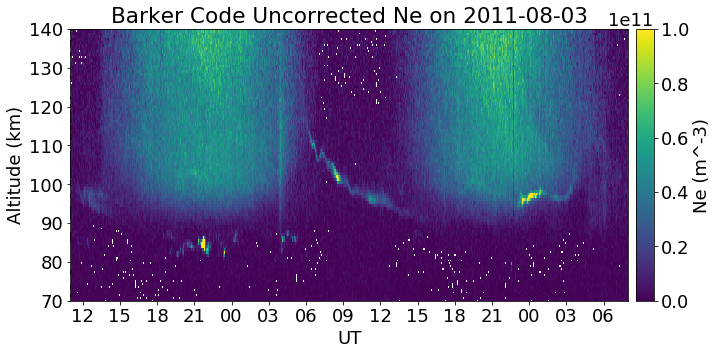

In [10]:
plt.rcParams['figure.figsize']=10,5
plt.rcParams['font.size']=18
fig,ax=plt.subplots(1,1)
clrs = ax.pcolormesh(mdates.date2num(bdat['time']),bdat['altitude'],bdat['ne'],vmin=0,vmax=1e11)

ax.set_xlim([mdates.date2num(datetime.datetime(2011,8,3,11,0,0)),mdates.date2num(datetime.datetime(2011,8,5,8,0,0))])
ax.set_xticks(np.arange(mdates.date2num(datetime.datetime(2011,8,3,12,0,0)),mdates.date2num(datetime.datetime(2011,8,5,8,0,0)),3/24.0))
ax.set_ylim([70,140])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.set_xlabel('UT')
ax.set_ylabel('Altitude (km)')
ax.set_title('Barker Code Uncorrected Ne on 2011-08-03')

box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
cb.set_label('Ne (m^-3)')

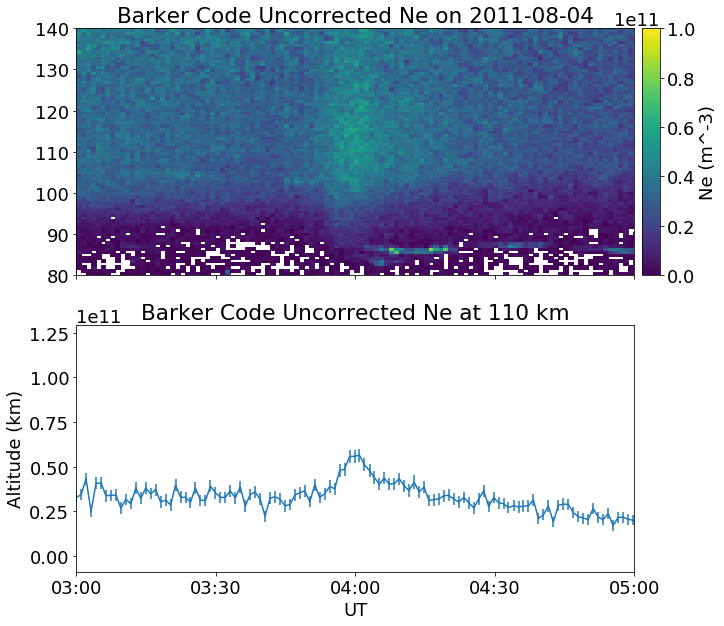

In [11]:
plt.rcParams['figure.figsize']=10,10
plt.rcParams['font.size']=18
fig,axarr=plt.subplots(2,1,sharex=True)
clrs = axarr[0].pcolormesh(mdates.date2num(bdat['time']),bdat['altitude'],bdat['ne'],vmin=0,vmax=1e11)
axarr[0].set_ylim([80,140])

#Pick out 110 km
a=np.argmin(np.abs(bdat['altitude']-110.0))
axarr[1].errorbar(mdates.date2num(bdat['time']),bdat['ne'][a,:],yerr=bdat['dne'][a,:])

axarr[-1].set_xlim([mdates.date2num(datetime.datetime(2011,8,4,3,0,0)),mdates.date2num(datetime.datetime(2011,8,4,5,0,0))])
axarr[-1].set_xticks(np.arange(mdates.date2num(datetime.datetime(2011,8,4,3,0,0)),mdates.date2num(datetime.datetime(2011,8,4,5,0,0)),0.5/24.0))


axarr[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axarr[-1].set_xlabel('UT')
axarr[-1].set_ylabel('Altitude (km)')
axarr[0].set_title('Barker Code Uncorrected Ne on 2011-08-04')
axarr[1].set_title('Barker Code Uncorrected Ne at 110 km')

box=axarr[0].get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
cb.set_label('Ne (m^-3)')

# Questions

1. The first plot shows 2 days-worth of data in UT time. Where are sunrise and sunset on each day? How can you tell even if the time axis wasn't labled?

2. The zoomed in second plot shows a special event at 4 UT. What happened? (Hint, you may find it useful to look at the NOAA GOES X-ray Data: GOES X-ray data ftp://ftp.swpc.noaa.gov/pub/warehouse/2011/ ftp://ftp.swpc.noaa.gov/pub/warehouse/2011/2011_plots/2011_xray.tar.gz ftp://ftp.swpc.noaa.gov/pub/warehouse/2011/2011_events.tar.gz)

## Extra Questions

3. What are the thin layers of electron density in the zoomed out plot between 90 and 110 km?

4. What are the thin layers of scatter between 80 and 90 km? (Hint, this is summer-time data, and those echoes are not actually incoherent scatter from electron density enhancements).